## Line profile and Gaussian curve fitting to the intensity line profile

- http://experimentationlab.berkeley.edu/sites/default/files/MOT/Gaussian-Beam-Optics.pdf
- https://www.mathworks.com/help/images/intensity-profile-of-images.html

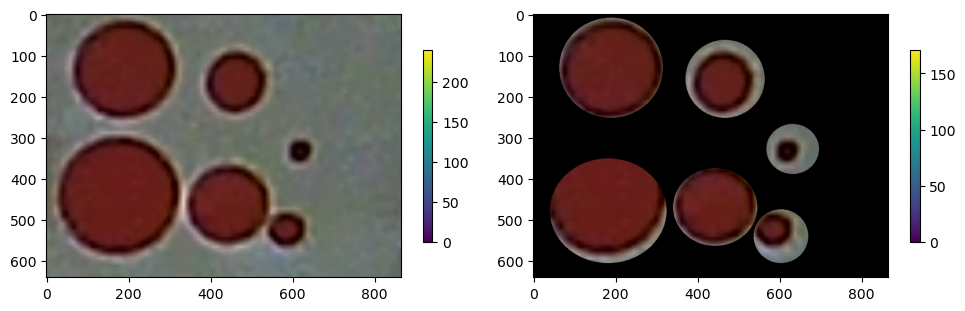

In [37]:
# Import the necessary functions from misc
from gaussian_curve import load_pair, gaussian, normalize, subtract_mask, plot_side_by_side, plot_line_profile
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage import io, exposure
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.stats import ks_2samp

# Define the paths to your image and mask
input_image = ".././data/images/image1.JPG"
mask_path = ".././data/templates/second_masked_template.png"

# Load image and mask pair
mask, image = load_pair(input_image, mask_path)

# Plot side-by-side original image and masked image
plot_side_by_side(image, image * np.expand_dims(mask, axis=2))

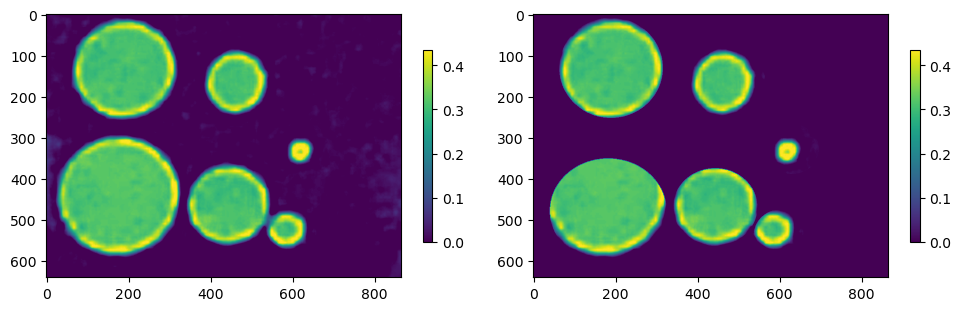

In [38]:
# Normalize and subtract mask
image_norm = normalize(image)
image_sub = subtract_mask(image_norm, mask)

# Plot side-by-side normalized and subtracted mask images
plot_side_by_side(image_norm, image_sub)

### Here the hyperparameters are yc (line drawan along y axis to the center of circle of 1cm circle sized), x_start (start of one edge of circle of 1cm), x_end (end of other edge of circle of 1 cm) should be changed so that drawn line will be located through the center of circle 1cm.

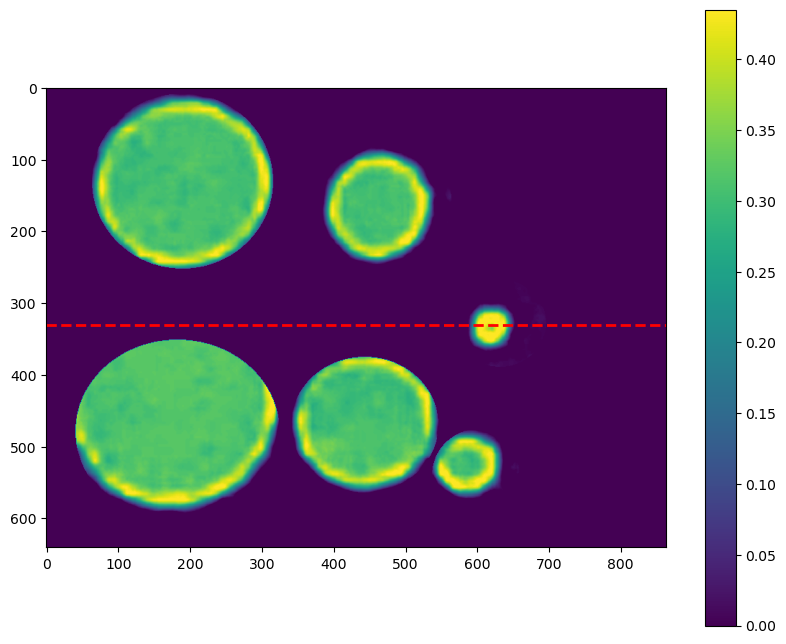

In [39]:
# Plot line profiles
yc = 330 #this should be changed as per the location of circle along y axis to make red color line
x_start = 550   #this should be the start along the x axis from where we want to study the line profile of red color circle put that value
x_end = 700   #this should be the start along the x axis upto where we want to study the line profile of red color circle put that value
sm = 1.   #here the sigma can put none because at the down we are going to use sigma value that best fitted our datasets

x_vals, line_profiles = plot_line_profile(image_norm=image, yc=yc, x_start=x_start, x_end=x_end, sm=sm)
plt.figure(figsize=(10, 8))

# Plot line profiles on the subtracted image
#for channel, color in enumerate(['red', 'green', 'blue']):
#    plt.plot(x_vals, line_profiles[channel], label=f'{color.capitalize()} Channel', color=color)

# Display the subtracted image with the custom colormap
plt.imshow(image_sub)  # Adjust the colormap as needed

# Overlay a red line on the subtracted image at the line profile position
#plt.axvline(x_start, color='yellow', linestyle='--', linewidth=2)
#plt.axvline(x_end, color='yellow', linestyle='--', linewidth=2)
plt.axhline(yc, color = "red", linestyle='--', linewidth=2)

plt.colorbar()
plt.show()

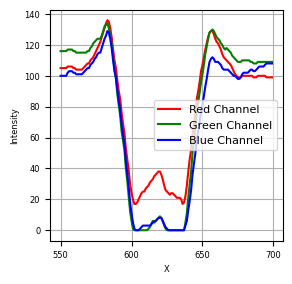

In [40]:
# Plot line profiles
x_vals, line_profiles = plot_line_profile(image_norm=image, yc=yc, x_start=x_start, x_end=x_end, sm=1.)
plt.figure(figsize=(3, 3))
for channel, color in enumerate(['red', 'green', 'blue']):
    plt.plot(x_vals, line_profiles[channel], label=f'{color.capitalize()} Channel', color=color)

plt.xlabel('X', fontsize=6)
plt.ylabel('Intensity', fontsize=6)
plt.legend(fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid()
plt.show()

### Extracting only the red color channel for fitting the gaussian curve

In [41]:
# Extract the red color channel
line_profile_red = line_profiles[0]  # Assuming red is the first channel

In [42]:
# Increase the number of data points for the x-axis
x_vals_interpolated_red = np.linspace(min(x_vals), max(x_vals), num=1000)

In [43]:
# Interpolate the line_profile_red to match the number of data points
line_profile_interpolated_red = interp1d(x_vals, line_profile_red, kind='linear')(x_vals_interpolated_red)

In [44]:
#find the location (x-value) of the peak in the line profile
peak_location = 610  #this value should be used where the peak or amplitude of gaussian curve is located along x axis

### Here the initial guesses value should be provided for amplitude, sigma and in the bounds_red sigma value should be changed so that the gaussian curve best fitted the intensity line profile. Starts from small number to large.

In [45]:
# Fit the Gaussian function to the interpolated line profile for the red color channel
initial_guess_red = [20, peak_location, 0.2, 20]  #this is the initial value which we provide
bounds_red = ([0, -np.inf, 0, -np.inf], [np.inf, np.inf, 40, np.inf])   #here, use value of sigma that covers all or most of your intensity line profile datasets, any value
params_red, _ = curve_fit(gaussian, x_vals_interpolated_red, line_profile_interpolated_red, p0=initial_guess_red, maxfev=200000000, bounds=bounds_red)

In [46]:
# Generate the fitted Gaussian curve for the red color channel with more data points
fitted_curve_red = gaussian(x_vals_interpolated_red, *params_red)

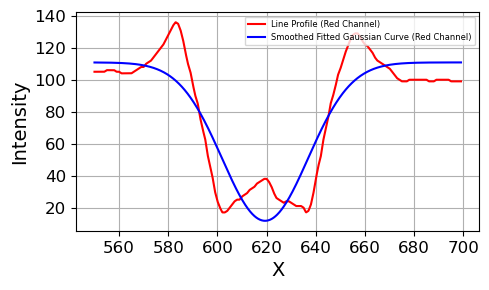

In [47]:
# Create a plot for the line profile and the smoothed Gaussian curve for the red color channel
plt.figure(figsize=(5, 3))
plt.plot(x_vals_interpolated_red, line_profile_interpolated_red, label='Line Profile (Red Channel)', color='red')
plt.plot(x_vals_interpolated_red, fitted_curve_red, label='Smoothed Fitted Gaussian Curve (Red Channel)', color='blue')
plt.xlabel('X', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.legend(fontsize=6)
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
#plt.savefig('smoothed_fitted_gaussian_curve_red_line_profile.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Save the amplitude, sigma and mean in npy for further interpretaion and analysis

In [48]:
#save sigma, mean and amplitude in npy
output = "NPY"
image1_data = np.array([params_red[2], params_red[0], params_red[1]])
#print(params_red[0], params_red[1], params_red[2])
# Save the NumPy array to a .npy file
output_path = os.path.join(output, "image1.npy")
np.save(output_path, image1_data)